In [ ]:
import os, random
import numpy as np
import cv2
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

# ===================== CONFIG =====================
IMG_HEIGHT, IMG_WIDTH = 256, 256
SEED = 42
BATCH_SIZE = 8

# COCO paths
COCO_DIR = "coco2017"
COCO_IMG_DIR = os.path.join(COCO_DIR, "train2017")
COCO_ANN_FILE = os.path.join(COCO_DIR, "annotations", "instances_train2017.json")

# ===================== PREPROCESS =====================
def preprocess_image(img_path):
    # Read image in BGR format
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    # Resize to model input size
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)
    # Normalize to [0, 1]
    img = img.astype(np.float32) / 255.0
    # Convert BGR → RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def preprocess_mask(mask):
    # Resize to model input size
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    # Ensure binary (0 or 1)
    mask = np.where(mask > 0, 1, 0).astype(np.float32)
    # Add channel dimension (H, W, 1)
    return np.expand_dims(mask, axis=-1)


# ===================== COCO LOADER =====================
def load_coco_pairs(coco, img_dir, target_cats=None):
    """Return (img_path, anns) pairs where anns contains COCO annotations"""
    if target_cats:
        cat_ids = coco.getCatIds(catNms=target_cats)
        img_ids = coco.getImgIds(catIds=cat_ids)
    else:
        img_ids = coco.getImgIds()

    pairs = []
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(img_dir, img_info["file_name"])
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids, iscrowd=None)
        anns = coco.loadAnns(ann_ids)
        if len(anns) > 0:
            pairs.append((img_path, anns, img_info))
    return pairs

def ann_to_mask(coco, ann, img_info):
    """Convert polygon/RLE annotation to binary mask"""
    mask = coco.annToMask(ann)
    return mask

# ===================== DATA GENERATOR =====================
def coco_generator(pairs, batch_size=BATCH_SIZE, augment=False):
    while True:
        random.shuffle(pairs)
        for i in range(0, len(pairs), batch_size):
            batch = pairs[i:i + batch_size]
            imgs, masks = [], []
            for img_path, anns, img_info in batch:
                # preprocess image
                img = preprocess_image(img_path)

                # empty mask
                mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

                # merge all masks for target objects
                for ann in anns:
                    m = ann_to_mask(coco, ann, img_info)
                    mask = np.maximum(mask, m)   # union of masks

                mask = preprocess_mask(mask)

                # augmentation: horizontal flip
                if augment and random.random() > 0.5:
                    img = np.fliplr(img)
                    mask = np.fliplr(mask)

                imgs.append(img)
                masks.append(mask)

            yield np.array(imgs, dtype=np.float32), np.array(masks, dtype=np.float32)


# ===================== LOAD COCO DATASET =====================
coco = COCO(COCO_ANN_FILE)
target_cats = ["person"]

# Get category IDs from names
cat_ids = coco.getCatIds(catNms=target_cats)
print("Target category IDs:", cat_ids)

# Get all image IDs that contain these categories
img_ids = coco.getImgIds(catIds=cat_ids)
print("Images matching targets:", len(img_ids))

# Load annotations (masks) for those categories
anns = coco.loadAnns(coco.getAnnIds(imgIds=img_ids, catIds=cat_ids))

# Create image-mask pairs (update your function to filter by target_cats)
coco_pairs = load_coco_pairs(coco, COCO_IMG_DIR, target_cats)

# Split into train/validation sets
train_coco, val_coco = train_test_split(coco_pairs, test_size=0.2, random_state=SEED)
print("Train samples:", len(train_coco))
print("Val samples:", len(val_coco))

# Generators
train_gen = coco_generator(train_coco, batch_size=BATCH_SIZE, augment=False)
val_gen = coco_generator(val_coco, batch_size=BATCH_SIZE, augment=False)

loading annotations into memory...
Done (t=13.52s)
creating index...
index created!
Target category IDs: [1]
Images matching targets: 64115
Coco Pairs: 262465
Coco Pairs: 64115
Train samples: 51292
Val samples: 12823


In [ ]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * inter + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

def sobel_edges(tensor):
    # Add epsilon to avoid numerical issues
    gx = tf.image.sobel_edges(tensor)[..., 0]
    gy = tf.image.sobel_edges(tensor)[..., 1]
    # Add small epsilon to prevent sqrt(0) and numerical instability
    return tf.sqrt(gx**2 + gy**2 + 1e-10)

def edge_loss(y_true, y_pred):
    y_true_edges = sobel_edges(y_true)
    y_pred_edges = sobel_edges(y_pred)
    # Use mean squared error instead of absolute difference for better stability
    return tf.reduce_mean(tf.square(y_true_edges - y_pred_edges))

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = 1.0 - dice_coef(y_true, y_pred)
    edge = edge_loss(y_true, y_pred)
    # Start with much smaller weight for edge loss
    return bce + dice + 0.3 * edge  # Reduced from 0.5 to 0.1

def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    tp = tf.reduce_sum(y_true_f * y_pred_f)
    fp = tf.reduce_sum((1 - y_true_f) * y_pred_f)
    fn = tf.reduce_sum(y_true_f * (1 - y_pred_f))
    return 1 - (tp + smooth) / (tp + alpha * fp + beta * fn + smooth)

def combined_tversky_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    tversky = tversky_loss(y_true, y_pred)
    edge = edge_loss(y_true, y_pred)
    return bce + tversky + 0.2 * edge  # can tune the edge weight

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    return x

def build_unet_with_resnet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    base_model = ResNet50(input_shape=input_shape, include_top=False, weights="imagenet")

    # Skip connections
    skip1 = base_model.get_layer("conv1_relu").output       # 128x128
    skip2 = base_model.get_layer("conv2_block3_out").output # 64x64
    skip3 = base_model.get_layer("conv3_block4_out").output # 32x32
    skip4 = base_model.get_layer("conv4_block6_out").output # 16x16
    x = base_model.get_layer("conv5_block3_out").output     # 8x8

    # Decoder
    x = layers.Conv2DTranspose(256, 3, strides=2, padding="same")(x)  # 16x16
    x = layers.Concatenate()([x, skip4])
    x = conv_block(x, 256)

    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)  # 32x32
    x = layers.Concatenate()([x, skip3])
    x = conv_block(x, 128)

    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)   # 64x64
    x = layers.Concatenate()([x, skip2])
    x = conv_block(x, 64)

    x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)   # 128x128
    x = layers.Concatenate()([x, skip1])
    x = conv_block(x, 32)

    x = layers.Conv2DTranspose(16, 3, strides=2, padding="same")(x)   # 256x256
    x = conv_block(x, 16)

    # Output
    outputs = layers.Conv2D(1, 1, activation="sigmoid")(x)

    model = keras.Model(inputs=base_model.input, outputs=outputs)
    return model

# Build & compile
model = build_unet_with_resnet()
initial_lr = 1e-4
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_lr, first_decay_steps=5000, t_mul=2.0, m_mul=0.9, alpha=1e-6
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipvalue=1.0),
    loss="binary_crossentropy",
    metrics=[dice_coef, iou_coef]
)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# Epoch configs
EPOCHS = 80

# Checkpont
checkpoint = "coco_rn.h5"
if os.path.exists(checkpoint):
    print(f"Loading model from {checkpoint}...")
    model.load_weights(checkpoint)  # load saved weights

# Callbacks
callbacks_coco = [
    ModelCheckpoint(checkpoint, save_best_only=True, monitor='val_loss', verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
]

# Model training
print(">>> Starting training on COCO...")
model.fit(
    train_gen,                 
    validation_data=val_gen,  
    steps_per_epoch=1000,
    validation_steps=200,
    epochs=EPOCHS,
    callbacks=callbacks_coco
)

>>> Starting training on COCO...
Epoch 1/80
1000/1000 [==============================] - ETA: 0s - loss: 0.3534 - dice_coef: 0.5078 - iou_coef: 0.3479
Epoch 1: val_loss improved from inf to 0.21487, saving model to coco_rn.h5
1000/1000 [==============================] - 224s 217ms/step - loss: 0.3534 - dice_coef: 0.5078 - iou_coef: 0.3479 - val_loss: 0.2149 - val_dice_coef: 0.5739 - val_iou_coef: 0.4081
Epoch 2/80
1000/1000 [==============================] - ETA: 0s - loss: 0.2286 - dice_coef: 0.6107 - iou_coef: 0.4472
Epoch 2: val_loss improved from 0.21487 to 0.18933, saving model to coco_rn.h5
1000/1000 [==============================] - 240s 240ms/step - loss: 0.2286 - dice_coef: 0.6107 - iou_coef: 0.4472 - val_loss: 0.1893 - val_dice_coef: 0.6608 - val_iou_coef: 0.4995
Epoch 3/80
1000/1000 [==============================] - ETA: 0s - loss: 0.1853 - dice_coef: 0.6602 - iou_coef: 0.5013
Epoch 3: val_loss improved from 0.18933 to 0.15038, saving model to coco_rn.h5
1000/1000 [=======

1/1 [==============================] - 1s 902ms/step


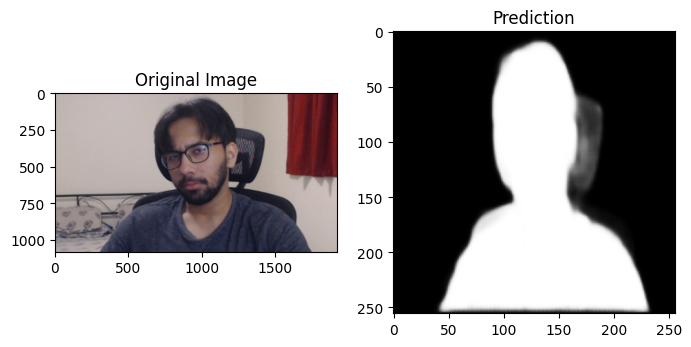

1/1 [==============================] - 0s 25ms/step


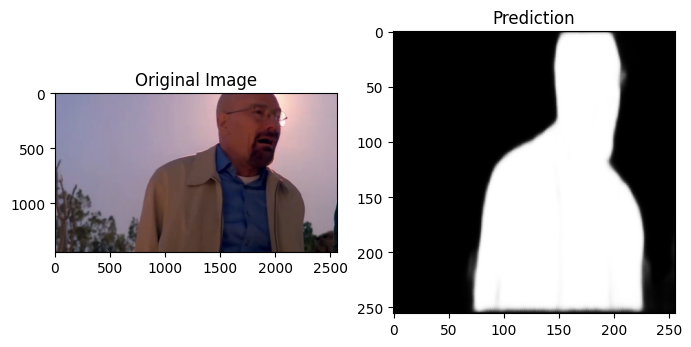

In [ ]:
# Testing on custom images
def test_on_custom_image(img_path):
    # Read and preprocess image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (IMG_WIDTH, IMG_HEIGHT))
    img_norm = img_resized / 255.0

    # Predict
    pred = model.predict(np.expand_dims(img_norm, axis=0))[0]

    # Show results
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.imshow(img_rgb); plt.title("Original Image")
    plt.subplot(1,2,2); plt.imshow(pred.squeeze(), cmap='gray'); plt.title("Prediction")
    plt.show()

# 🖼️ Example usage:
test_on_custom_image(r"C:\Users\Hamza\Desktop\test\frame.png")
test_on_custom_image(r"C:\Users\Hamza\Desktop\test\frame2.png")

In [ ]:
model.save("segmentation_model")

INFO:tensorflow:Assets written to: segmentation_model\assets


INFO:tensorflow:Assets written to: segmentation_model\assets


In [20]:
# Converitng the model to ONNX format
!python -m tf2onnx.convert --saved-model ./segmentation_model --output ../web-ui/public/model.onnx

c:\Users\Hamza\anaconda3\envs\gpu\lib\runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2025-08-23 23:50:17,307 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2025-08-23 23:50:23,132 - INFO - Signatures found in model: [serving_default].
2025-08-23 23:50:23,132 - WARNING - '--signature_def' not specified, using first signature: serving_default
2025-08-23 23:50:23,134 - INFO - Output names: ['conv2d_43']
2025-08-23 23:50:27,883 - INFO - Using tensorflow=2.10.1, onnx=1.17.0, tf2onnx=1.16.1/15c810
2025-08-23 23:50:27,883 - INFO - Using opset <onnx, 15>
2025-08-23 23:50:28,790 - INFO - Computed 0 values for constant folding
2025-08-23 23:50:30,570 - INFO - Optimizing ONNX model
2025-08-23 23:50:34,811 - INFO - After optimization: Add -1 (17->16), BatchNormalization -53 (63->10), Cast -5 (5->0), Concat